In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from data import FloodEventDataset
from data.boundary_condition import BoundaryCondition
from data.dataset_normalizer import DatasetNormalizer
from matplotlib.patches import Patch
from typing import Tuple
from utils import file_utils, metric_utils

### Training Stats

In [2]:
# # Main Results
# training_stats_paths = [
#     'stc/train/GAT_2025-08-10_08-39-08_train_stats.npz',
#     'stc/train/GCN_2025-08-10_08-41-24_train_stats.npz',
#     'stc/train/NodeEdgeGNNAttn_2025-08-10_11-55-42_train_stats.npz',
# ]
# labels = ['GAT', 'GCN', 'NodeEdgeGNNAttn']

# training_stats_paths = [
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_15-19-28_auto1_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_15-53-01_auto2_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_16-17-40_auto3_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_16-35-30_auto4_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_17-48-41_auto6_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-17_19-42-40_auto8_train_stats.npz',
#     'auto_no_physics_modified/train/NodeEdgeGNN_2025-09-18_02-51-44_auto10_train_stats.npz',
# ]
# labels = ['Supervised', '2-step', '3-step', '4-step', '6-step', '8-step', '10-step']

# training_stats_paths = [
#     'physics_informed/train/NodeEdgeGNN_2025-09-18_11-55-29_base_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_15-01-54_global_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_17-13-24_global_0.1_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_18-30-46_global_0.01_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_19-56-45_global_0.001_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_21-42-26_global_0.0001_train_stats.npz',
# ]
# labels = ['Base', 'Global 1', 'Global 0.1', 'Global 0.01', 'Global 0.001', 'Global 0.0001']

# training_stats_paths = [
#     'physics_informed/train/NodeEdgeGNN_2025-09-18_11-55-29_base_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-18_19-32-16_local_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_11-52-15_local_0.1_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-18_22-22-16_local_0.01_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-18_23-54-52_local_0.001_train_stats.npz',
#     'physics_informed/train/NodeEdgeGNN_2025-09-19_13-21-48_local_0.0001_train_stats.npz',
# ]
# labels = ['Base', 'Local 1', 'Local 0.1', 'Local 0.01', 'Local 0.001', 'Local 0.0001']

training_stats_paths = [
    'physics_informed/train/NodeEdgeGNN_2025-09-18_11-55-29_base_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-09-19_18-30-46_global_0.01_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-09-18_22-22-16_local_0.01_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-09-21_19-24-40_global_local_train_stats.npz'
]
labels = ['Base', 'Global', 'Local', 'Global and Local']

# training_stats_paths = [
#     'experiment_w_variations/train/NodeEdgeGNN_2025-09-20_17-11-56_base_train_stats.npz',
#     'experiment_w_variations/train/NodeEdgeGNNAttn_2025-09-20_18-32-39_train_stats.npz',
# ]
# labels = ['Base', 'Attention']

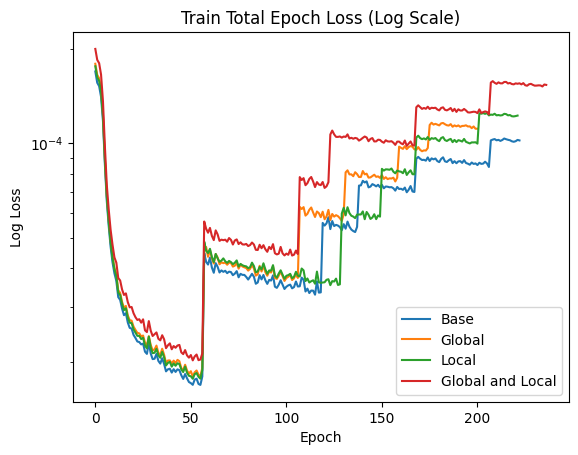

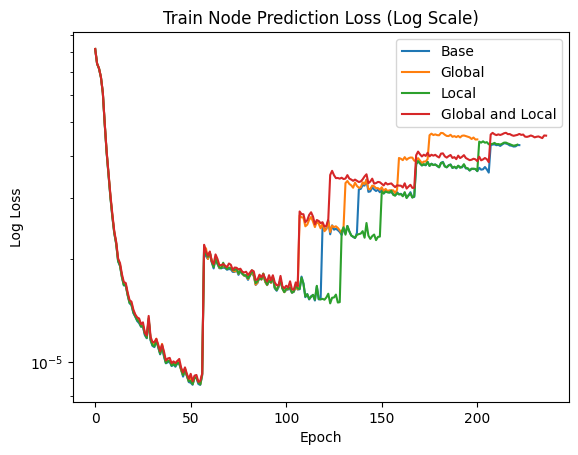

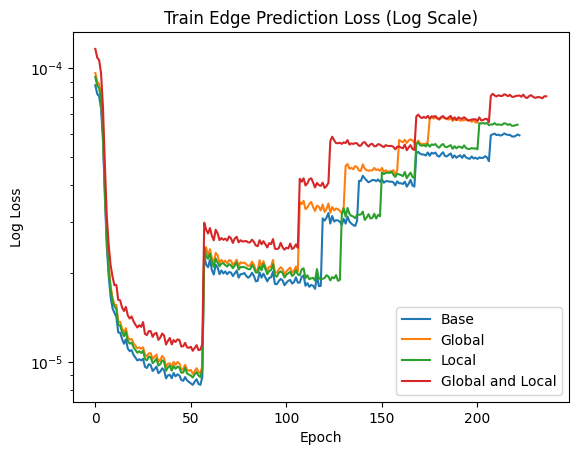

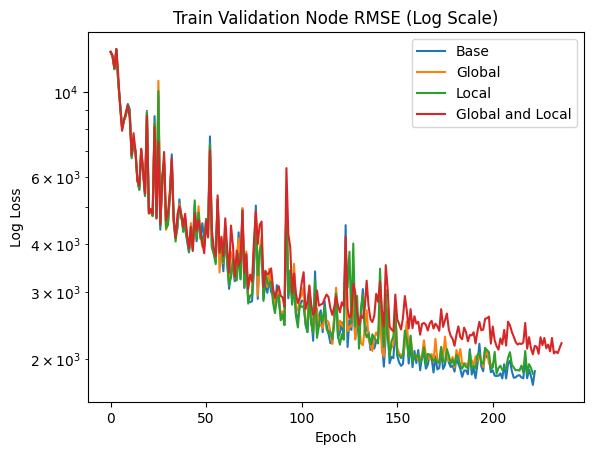

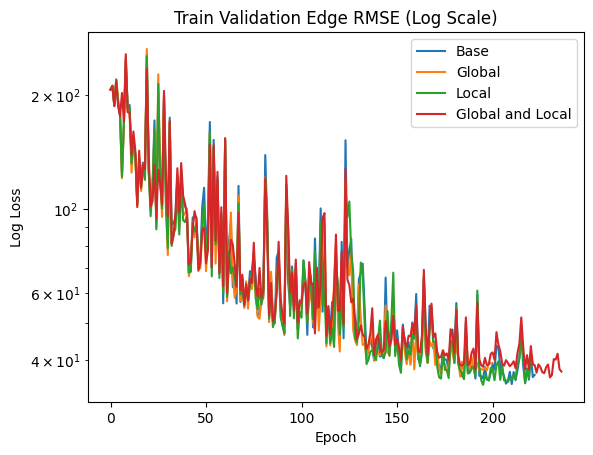

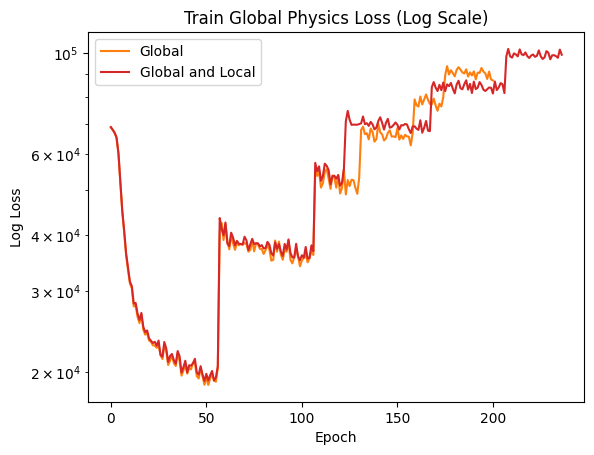

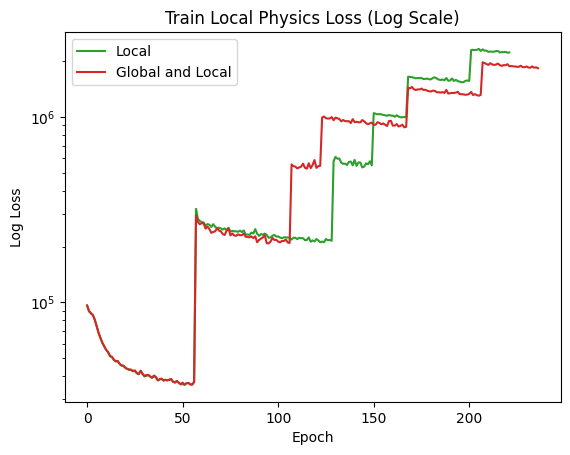

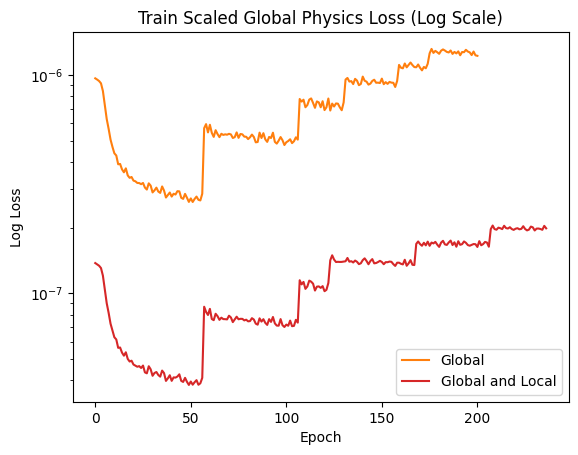

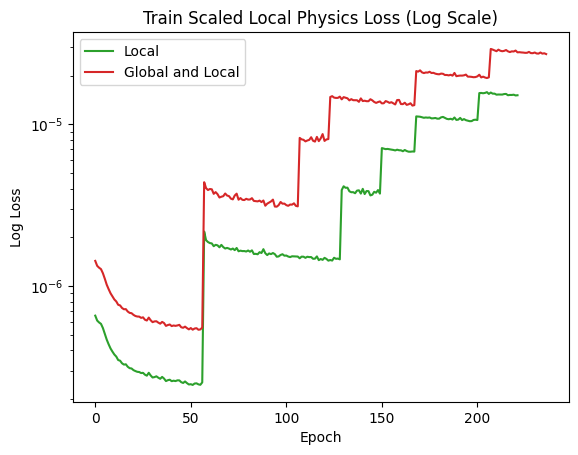

In [3]:
def plot_training_loss_for_all_models(stats_paths: list[str], metric: str, metric_name: str, start_epoch: int = 0, labels = None, log_scale: bool = False):
    is_metric_present = False
    for i, path in enumerate(stats_paths):
        label = labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        train_stats = np.load(path, allow_pickle=True)
        if metric not in train_stats:
            continue

        is_metric_present = True
        train_loss = train_stats[metric][start_epoch:]
        color = f'C{i % 10}'
        plt.plot(train_loss, label=label, color=color)

    if not is_metric_present:
        print(f"Metric '{metric}' not found in any of the provided training stats paths.")
        return

    title = metric_name if metric_name is not None else metric.replace('_', ' ').title()

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'Train {title} (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'Train {title}')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

start_epoch = 0
metrics = ['train_epoch_loss', 'prediction_loss', 'edge_prediction_loss', 'val_node_rmse', 'val_edge_rmse']
metric_names = ['Total Epoch Loss', 'Node Prediction Loss', 'Edge Prediction Loss', 'Validation Node RMSE', 'Validation Edge RMSE']

# Original Physics Loss
metrics += ['orig_global_physics_loss', 'orig_local_physics_loss']
metric_names += ['Global Physics Loss', 'Local Physics Loss']

# Scaled Physics Loss
metrics += ['global_physics_loss', 'local_physics_loss']
metric_names += ['Scaled Global Physics Loss', 'Scaled Local Physics Loss']

for metric, metric_name in zip(metrics, metric_names):
    plot_training_loss_for_all_models(training_stats_paths, metric, metric_name, start_epoch=start_epoch, labels=labels, log_scale=True)

Component 'global_physics_loss' not found in physics_informed/train/NodeEdgeGNN_2025-09-18_11-55-29_base_train_stats.npz. Skipping.
Component 'local_physics_loss' not found in physics_informed/train/NodeEdgeGNN_2025-09-18_11-55-29_base_train_stats.npz. Skipping.


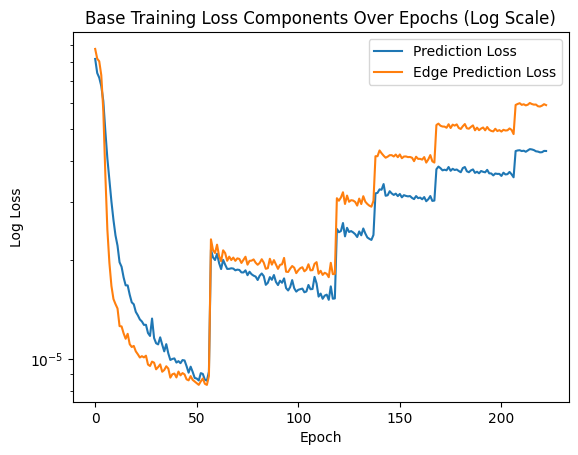

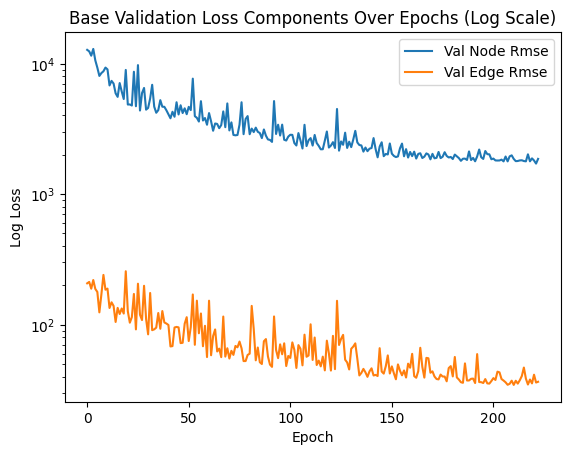

In [4]:
def plot_individual_training_loss(path: str, start_epoch: int = 0, model_label: str = '', log_scale: bool = False):
    loss_components = ['prediction_loss', 'global_physics_loss', 'local_physics_loss']

    model_name = os.path.basename(path).split('_')[0]
    if 'Edge' in model_name:
        loss_components.append('edge_prediction_loss')

    for component in loss_components:
        train_loss = np.load(path, allow_pickle=True)
        if component not in train_loss:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_loss = train_loss[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_loss, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def plot_individual_training_val_loss(path: str, model_label: str = '', log_scale: bool = False):
    loss_components = ['val_node_rmse', 'val_edge_rmse']

    for component in loss_components:
        train_data = np.load(path, allow_pickle=True)
        if component not in train_data:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_data = train_data[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_data, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

PATH_IDX = 0 # Change this index to select different training stats paths
label = labels[PATH_IDX] if labels is not None else None
plot_individual_training_loss(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label, log_scale=True)
plot_individual_training_val_loss(training_stats_paths[PATH_IDX], model_label=label, log_scale=True)

In [5]:
# def plot_individual_training_loss_ratio(path: str, start_epoch: int = 0, model_label: str = None):
#     loss_ratios = ['loss_ratios']
#     for ratio in loss_ratios:
#         train_loss_ratio = np.load(path, allow_pickle=True)[ratio]
#         train_loss_ratio = train_loss_ratio[start_epoch:]
#         label = ratio.replace('_', ' ').title()
#         plt.plot(train_loss_ratio, label=label)

#     plt.title(f'{model_label if model_label is not None else ''} Training Loss Ratio Over Epochs')
#     plt.xticks(np.arange(len(train_loss_ratio), step=5))
#     plt.ylabel('Ratio')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()

# plot_individual_training_loss_ratio(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label)

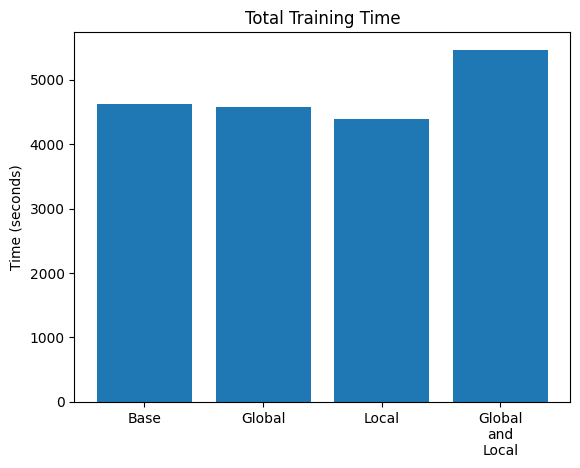

In [6]:
def plot_training_time_for_all_models(stats_paths: list[str], labels = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in stats_paths]
    labels = [label.replace(' ', '\n') for label in labels]
    assert len(stats_paths) == len(labels), "Number of labels must match number of stats paths."

    all_train_time = []
    for path in stats_paths:
        train_time = np.load(path, allow_pickle=True)['train_time']
        all_train_time.append(train_time.item())

    plt.bar(labels, all_train_time)
    plt.title('Total Training Time')
    plt.ylabel('Time (seconds)')
    plt.show()

plot_training_time_for_all_models(training_stats_paths, labels=labels)

### Overall Metric Comparison

In [7]:
RUN_ID = 39

# metric_paths = [
#     f'experiment_w_variations/test/NodeEdgeGNN_2025-09-20_17-11-56_base_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Base']

# # Main Results
# metric_paths = [
#     f'baseline/test/GAT_2025-09-19_01-22-21_autoregressive_runid_{RUN_ID}_test_metrics.npz',
#     f'baseline/test/GCN_2025-09-18_23-21-50_autoregressive_runid_{RUN_ID}_test_metrics.npz',
#     f'baseline/hydrographnet_test/HydroGraphNet_runid_{RUN_ID}_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_19-56-45_global_0.001_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_23-54-52_local_0.001_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['GAT', 'GCN', 'HydroGraphNet', 'Global Model', 'Local Model']

# metric_paths = [
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_15-19-28_auto1_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_15-53-01_auto2_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_16-17-40_auto3_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_16-35-30_auto4_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_17-48-41_auto6_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-17_19-42-40_auto8_runid_{RUN_ID}_test_metrics.npz',
#     f'auto_no_physics_modified/test/NodeEdgeGNN_2025-09-18_02-51-44_auto10_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Supervised', '2-step', '3-step', '4-step', '6-step', '8-step', '10-step']

# metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_11-55-29_base_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_15-01-54_global_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_17-13-24_global_0.1_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_18-30-46_global_0.01_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_19-56-45_global_0.001_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_21-42-26_global_0.0001_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Base', 'Global 1', 'Global 0.1', 'Global 0.01', 'Global 0.001', 'Global 0.0001']

# metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_11-55-29_base_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_19-32-16_local_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_11-52-15_local_0.1_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_22-22-16_local_0.01_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-18_23-54-52_local_0.001_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-09-19_13-21-48_local_0.0001_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Base', 'Local 1', 'Local 0.1', 'Local 0.01', 'Local 0.001', 'Local 0.0001']

metric_paths = [
    f'physics_informed/test/NodeEdgeGNN_2025-09-18_11-55-29_base_runid_{RUN_ID}_test_metrics.npz',
    f'physics_informed/test/NodeEdgeGNN_2025-09-19_18-30-46_global_0.01_runid_{RUN_ID}_test_metrics.npz',
    f'physics_informed/test/NodeEdgeGNN_2025-09-18_22-22-16_local_0.01_runid_{RUN_ID}_test_metrics.npz',
    f'physics_informed/test/NodeEdgeGNN_2025-09-21_19-24-40_global_local_runid_{RUN_ID}_test_metrics.npz',
]
labels = ['Base', 'Global', 'Local', 'Global and Local']

In [8]:
# Double check targets are the same
# EPS = 1e-5
EPS = 1e-1
comparison_target = None
comparison_edge_target = None
for path in metric_paths:
    print('Checking target for', path)
    data = np.load(path, allow_pickle=True)
    target = data['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'
    
    if 'edge_target' not in data:
        continue

    edge_target = data['edge_target']
    if comparison_edge_target is None:
        comparison_edge_target = edge_target
    else:
        assert np.all((comparison_edge_target - edge_target) < EPS), f'Edge targets are not equal for {path}'

Checking target for physics_informed/test/NodeEdgeGNN_2025-09-18_11-55-29_base_runid_39_test_metrics.npz
Checking target for physics_informed/test/NodeEdgeGNN_2025-09-19_18-30-46_global_0.01_runid_39_test_metrics.npz
Checking target for physics_informed/test/NodeEdgeGNN_2025-09-18_22-22-16_local_0.01_runid_39_test_metrics.npz
Checking target for physics_informed/test/NodeEdgeGNN_2025-09-21_19-24-40_global_local_runid_39_test_metrics.npz


In [9]:
def get_x_ticks_from_timestamps(metric_paths: list[str]) -> Tuple[list[str], str]:
    delta_t = None
    len_timestamps = None
    for path in metric_paths:
        data = np.load(path, allow_pickle=True)
        if 'timestamps' not in data:
            continue
        timestamps = data['timestamps']
        if timestamps is None or len(timestamps) == 0:
            continue

        assert len(timestamps) > 1, f"Expected more than one timestamp in {path}, found {len(timestamps)}."
        path_delta_t = timestamps[1] - timestamps[0]
        if delta_t is None:
            delta_t = path_delta_t
        assert delta_t == path_delta_t, f"Timestep interval mismatch for {path}: {delta_t} vs {path_delta_t}"
        if len_timestamps is None:
            len_timestamps = len(timestamps)
        assert len_timestamps == len(timestamps), f"Number of timestamps mismatch for {path}: {len_timestamps} vs {len(timestamps)}"
    
    if delta_t is None:
        x_ticks = np.arange(0, data['pred'].shape[0], step=10)
        return x_ticks, x_ticks, 'Timestep'

    TIME_INTERVAL_IN_HOURS = 12
    delta_t = delta_t.item()
    delta_t_in_hours = delta_t.total_seconds() / 3600
    step = TIME_INTERVAL_IN_HOURS / delta_t_in_hours
    x_ticks = np.concat([np.arange(0, len(timestamps), step=step), np.array([len(timestamps)-1])], axis=0)
    x_tick_labels = x_ticks * delta_t_in_hours
    return x_ticks, x_tick_labels, f'Time (hours)'


def plot_metric_for_all_models(metric_paths: list[str], metric: str, metric_name: str = None, labels: list[str] = None, log_scale: bool = False):
    split_metric = metric.split('_') 
    if metric_name is None:
        metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)
        if metric not in data or all(data[metric].shape) == 0:
            print(f"Metric '{metric}' is empty for path {path}. Skipping.")
            continue
        data = data[metric]

        print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label, color=f'C{i % 10}')

    if log_scale:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (Log Scale)')
        plt.title(f'Test {metric_name} for Event {event_name} (Log Scale)')
    else:
        plt.title(f'Test {metric_name} for Event {event_name}')
        plt.ylabel(metric_name)

    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.legend(framealpha=0)
    plt.show()

Average Node RMSE for NodeEdgeGNN: 2140.4949
Average Node RMSE for NodeEdgeGNN: 1951.7292
Average Node RMSE for NodeEdgeGNN: 2002.1018
Average Node RMSE for NodeEdgeGNN: 2358.2732


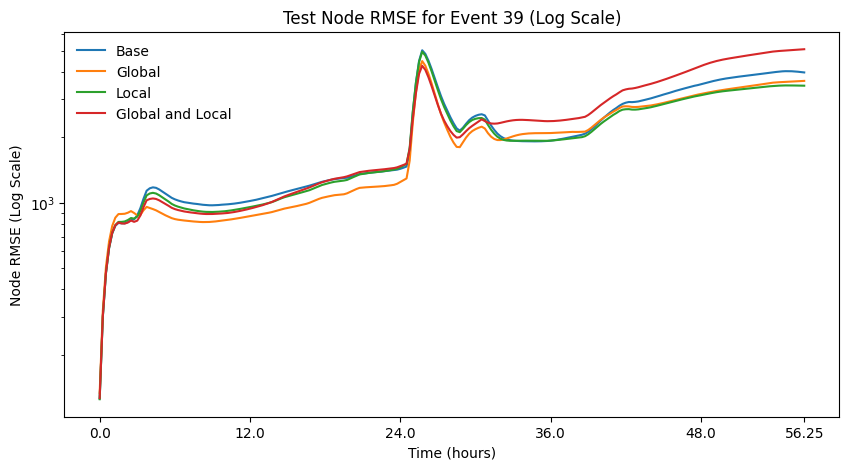

Average Node MAE for NodeEdgeGNN: 1209.0820
Average Node MAE for NodeEdgeGNN: 1135.3961
Average Node MAE for NodeEdgeGNN: 1137.2946
Average Node MAE for NodeEdgeGNN: 1242.0306


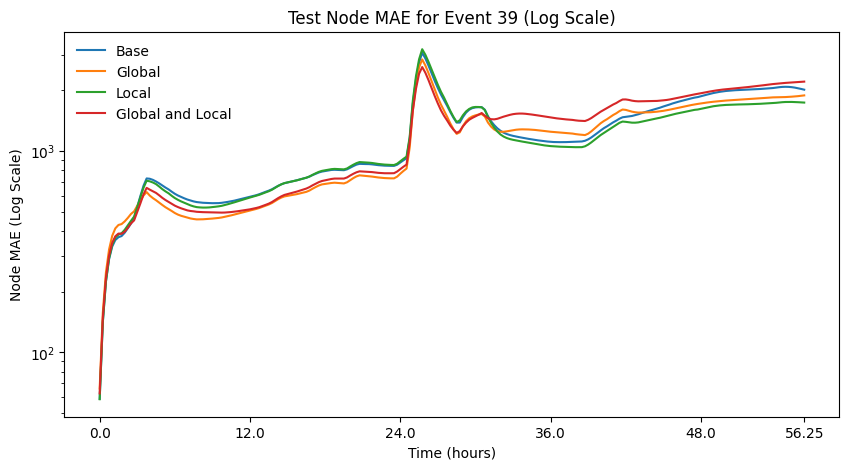

Average Node NSE for NodeEdgeGNN: 0.9870
Average Node NSE for NodeEdgeGNN: 0.9891
Average Node NSE for NodeEdgeGNN: 0.9884
Average Node NSE for NodeEdgeGNN: 0.9847


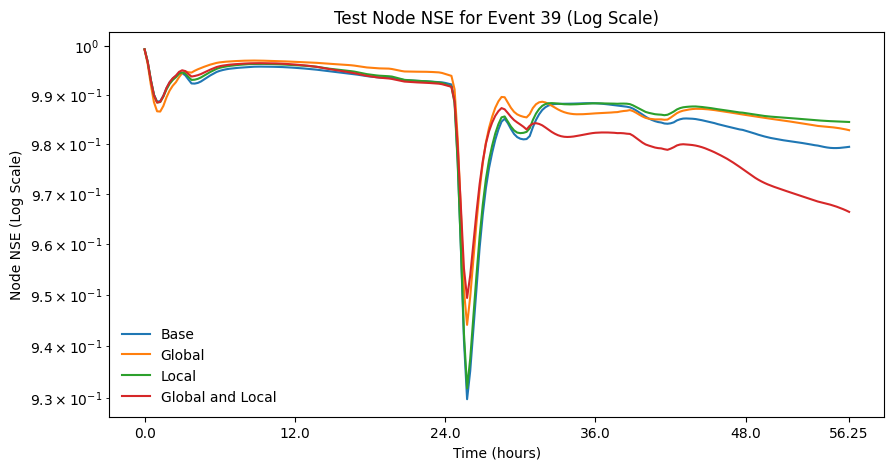

Average Node CSI for NodeEdgeGNN: 0.8886
Average Node CSI for NodeEdgeGNN: 0.8735
Average Node CSI for NodeEdgeGNN: 0.8951
Average Node CSI for NodeEdgeGNN: 0.8587


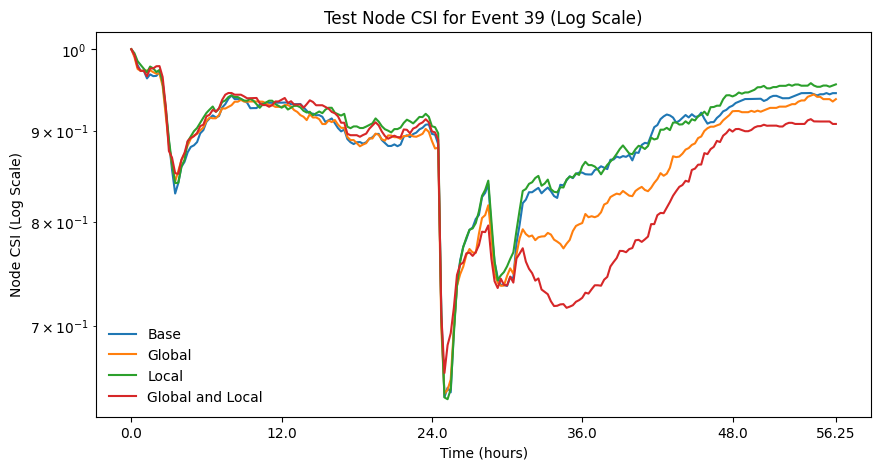

Average Node RMSE (flooded) for NodeEdgeGNN: 2924.1140
Average Node RMSE (flooded) for NodeEdgeGNN: 2599.8335
Average Node RMSE (flooded) for NodeEdgeGNN: 2729.9226
Average Node RMSE (flooded) for NodeEdgeGNN: 3098.7646


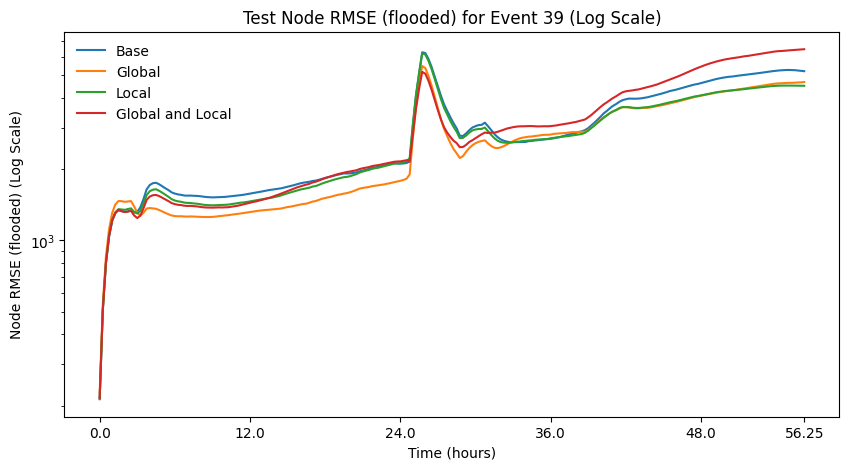

Average Node MAE (flooded) for NodeEdgeGNN: 1981.0381
Average Node MAE (flooded) for NodeEdgeGNN: 1754.3379
Average Node MAE (flooded) for NodeEdgeGNN: 1821.3094
Average Node MAE (flooded) for NodeEdgeGNN: 1916.6471


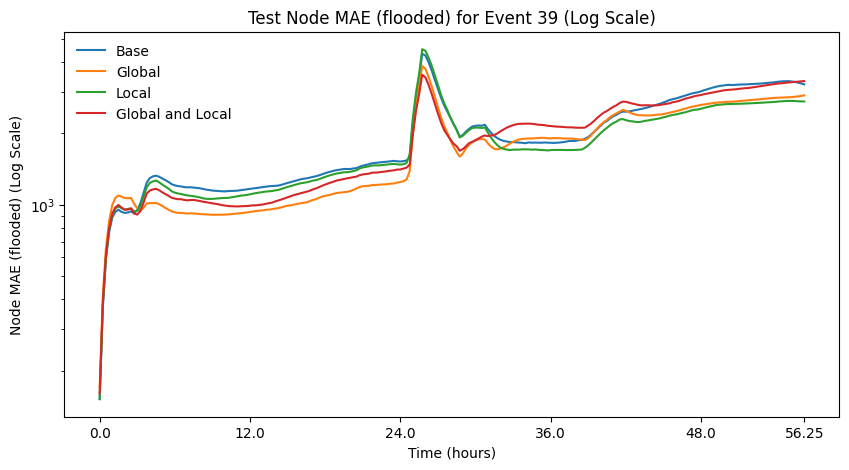

Average Node NSE (flooded) for NodeEdgeGNN: 0.9791
Average Node NSE (flooded) for NodeEdgeGNN: 0.9835
Average Node NSE (flooded) for NodeEdgeGNN: 0.9815
Average Node NSE (flooded) for NodeEdgeGNN: 0.9773


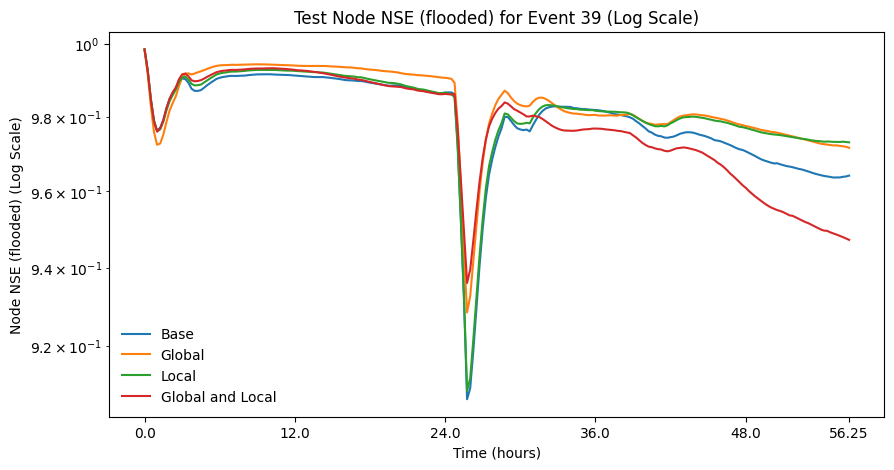

Average Global Mass Loss for NodeEdgeGNN: 81510.3495
Average Global Mass Loss for NodeEdgeGNN: 125362.0070
Average Global Mass Loss for NodeEdgeGNN: 60712.9056
Average Global Mass Loss for NodeEdgeGNN: 73709.1997


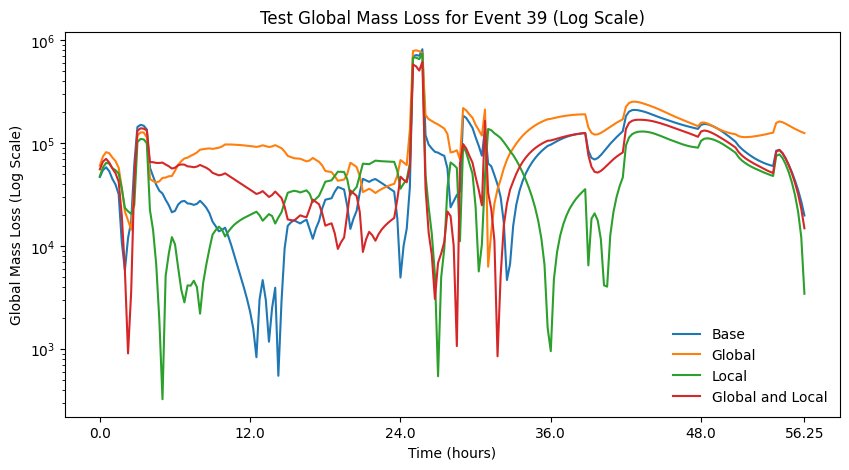

Average Local Mass Loss for NodeEdgeGNN: 28844366.6717
Average Local Mass Loss for NodeEdgeGNN: 27541977.2874
Average Local Mass Loss for NodeEdgeGNN: 20129666.7845
Average Local Mass Loss for NodeEdgeGNN: 20597243.2924


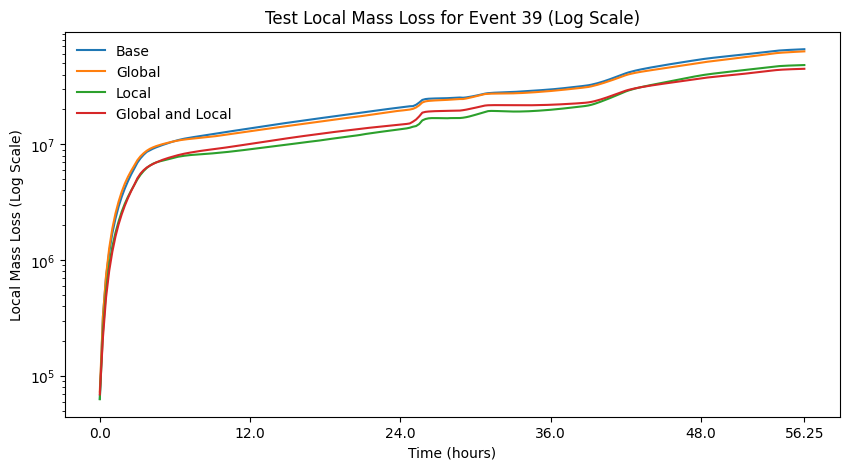

Average Edge RMSE for NodeEdgeGNN: 38.5040
Average Edge RMSE for NodeEdgeGNN: 37.1501
Average Edge RMSE for NodeEdgeGNN: 34.7719
Average Edge RMSE for NodeEdgeGNN: 37.0440


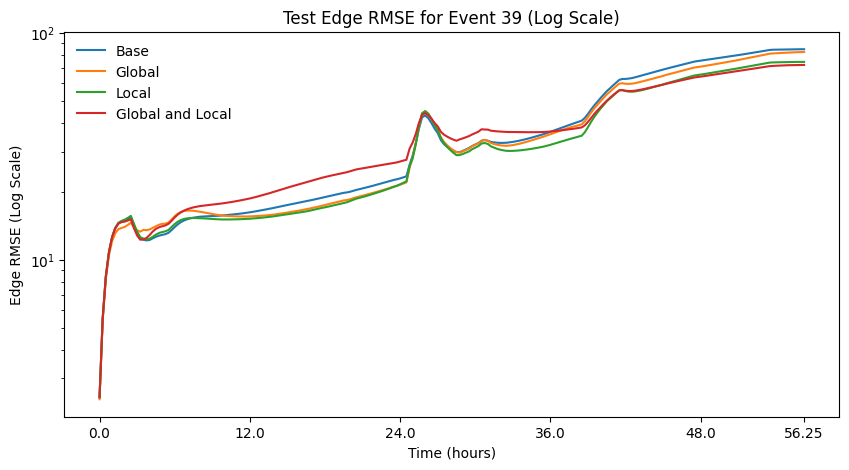

Average Edge MAE for NodeEdgeGNN: 13.7960
Average Edge MAE for NodeEdgeGNN: 13.7799
Average Edge MAE for NodeEdgeGNN: 12.2971
Average Edge MAE for NodeEdgeGNN: 12.2360


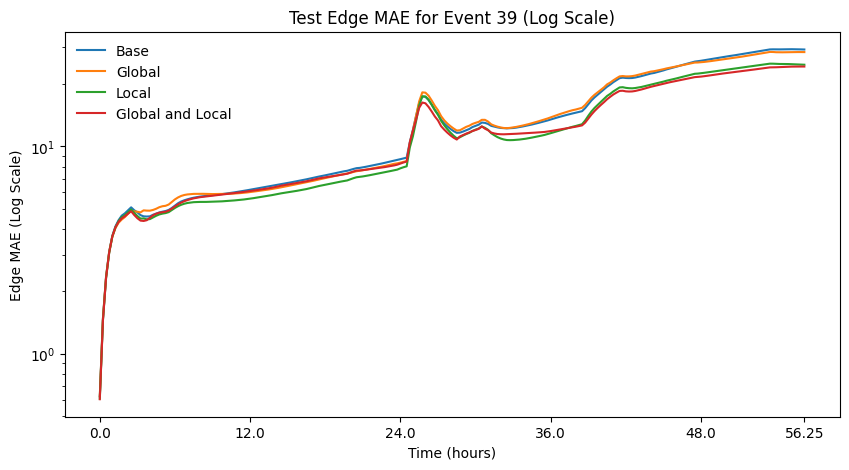

Average Edge NSE for NodeEdgeGNN: 0.9861
Average Edge NSE for NodeEdgeGNN: 0.9870
Average Edge NSE for NodeEdgeGNN: 0.9884
Average Edge NSE for NodeEdgeGNN: 0.9868


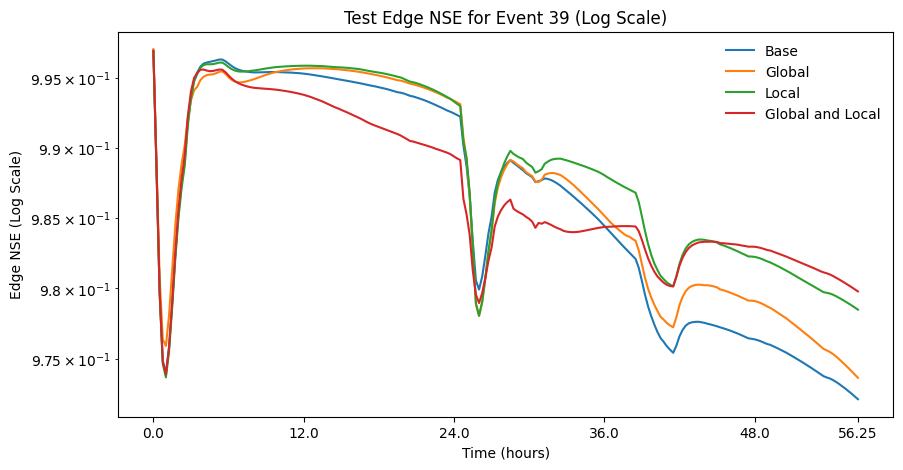

In [10]:
metrics = ['rmse', 'mae', 'nse', 'csi']
metric_names = ['Node RMSE', 'Node MAE', 'Node NSE', 'Node CSI']

# Flooded Node Metrics
metrics += ['rmse_flooded', 'mae_flooded', 'nse_flooded']
metric_names += ['Node RMSE (flooded)', 'Node MAE (flooded)', 'Node NSE (flooded)']

# Physics Metrics
metrics += ['global_mass_loss', 'local_mass_loss']
metric_names += ['Global Mass Loss', 'Local Mass Loss']

# Metrics for edge prediction
metrics += ['edge_rmse', 'edge_mae', 'edge_nse']
metric_names += ['Edge RMSE', 'Edge MAE', 'Edge NSE']

for metric, metric_name in zip(metrics, metric_names):
    plot_metric_for_all_models(metric_paths, metric, metric_name=metric_name, labels=labels, log_scale=True)

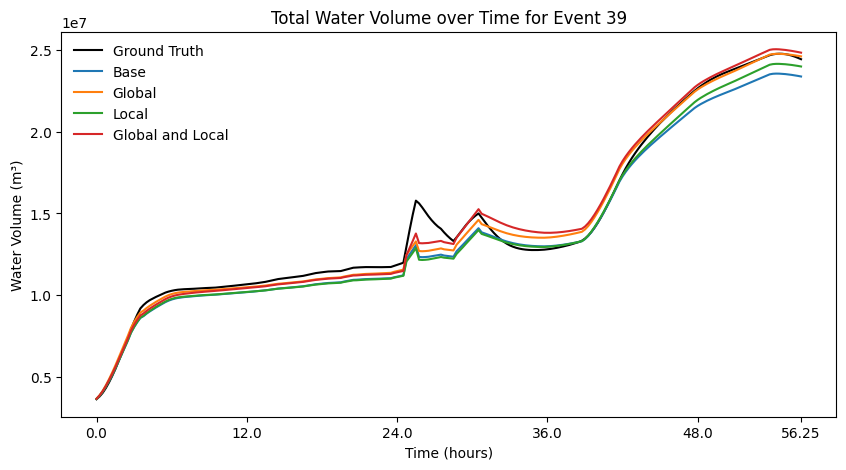

In [11]:
def plot_total_water_volume_for_all_models(metric_paths: list[str], ground_truth: np.ndarray = None, labels: list[str] = None, end_timestep: int = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'Total Water Volume over Time for Event {event_name}')

    if ground_truth is not None:
        gt_total_volume = ground_truth.sum(axis=1)
        if end_timestep is not None:
            gt_total_volume = gt_total_volume[:end_timestep]
        plt.plot(gt_total_volume, label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for path {path}: {data.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]
        if labels is not None:
            label = labels[i] if i < len(labels) else label

        pred_total_volume = data.sum(axis=1)
        if end_timestep is not None:
            pred_total_volume = pred_total_volume[:end_timestep]
        plt.plot(pred_total_volume, label=label)

    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.ylabel('Water Volume (m³)')
    plt.legend(framealpha=0)
    plt.show()

vol_ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_total_water_volume_for_all_models(metric_paths, ground_truth=vol_ground_truth, labels=labels)

### Node Analysis

In [12]:
# Nodes connected to boundary conditions
BOUNDARY_NODE_IDX = [718, 434, 858]
# Top 4 highest water differences
NODE_IDX_MAP = {
    13: [1026, 443, 208, 459], # Run ID 13
    14: [1026, 443, 459, 444], # Run ID 14
    15: [1022, 1023, 1026, 1082], # Run ID 15
    16: [1022, 1023, 1026, 1082], # Run ID 16
}
# SELECTED_NODE_IDX = NODE_IDX_MAP[RUN_ID] + BOUNDARY_NODE_IDX
SELECTED_NODE_IDX = [445, 657, 459, 533] # Nodes located at the river
node_idxs = SELECTED_NODE_IDX # + BOUNDARY_NODE_IDX

def plot_water_volume_for_node(node_idx: int, water_volume: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_volume.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')
    plt.plot(water_volume[:num_timesteps, node_idx], color='black')
    plt.show()

# for node_idx in node_idxs:
#     peak_wv = vol_ground_truth[:, node_idx].max()
#     peak_wv_timestep = vol_ground_truth[:, node_idx].argmax()
#     print(f"(Run ID {RUN_ID}) Peak water volume for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

#     # plot_water_volume_for_node(node_idx, vol_ground_truth)

In [20]:
def get_edge_index(constant_values_path: str):
    constant_values = np.load(constant_values_path, allow_pickle=True)
    edge_index = constant_values['edge_index']
    return edge_index

# def plot_node_water_values_for_all_models(metric_paths: list[str],
#                                           node_idx: int,
#                                           edge_index: np.ndarray,
#                                           ground_truths: Tuple[np.ndarray, np.ndarray] = (None, None),
#                                           labels: list[str] = None):
#     vol_ground_truth, flow_ground_truth = ground_truths

#     metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
#     if labels is None:
#         labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
#     plt.figure(figsize=(8, 4))
#     x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
#     handles = []

#     # Water Volume
#     # plt.text(1, 0.3, 'Water Volume', transform=ax[0].transAxes, rotation=270, fontsize=12)
#     plt.ylabel('Water Volume (m³)')
#     plt.xlabel(xlabel)
#     plt.xticks(ticks=x_ticks, labels=x_ticks_labels)

#     if vol_ground_truth is not None:
#        gt_line, = plt.plot(vol_ground_truth[:, node_idx], label='Ground Truth', color='black')
#        handles.append(gt_line)

#     data_shape = None
#     for i, data in enumerate(metrics):
#         pred = data['pred']

#         if data_shape is None:
#             data_shape = pred.shape
#         assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

#         line, = plt.plot(pred[:, node_idx], label=labels[i])
#         handles.append(line)

#     plt.title(f'Metrics Over Time for Node {node_idx}')
#     plt.legend(handles=handles, labels=['Ground Truth', *labels])
#     plt.subplots_adjust(left=0.15)
#     plt.tight_layout()

def plot_node_water_values_for_all_models(metric_paths: list[str],
                                          node_idx: int,
                                          edge_index: np.ndarray,
                                          ground_truths: Tuple[np.ndarray, np.ndarray] = (None, None),
                                          labels: list[str] = None):
    vol_ground_truth, flow_ground_truth = ground_truths

    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    handles = []

    # Water Volume
    ax[0].text(1, 0.3, 'Water Volume', transform=ax[0].transAxes, rotation=270, fontsize=12)
    ax[0].set_ylabel('Water Volume (m³)')
    ax[0].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if vol_ground_truth is not None:
       gt_line, = ax[0].plot(vol_ground_truth[:, node_idx], label='Ground Truth', color='black')
       handles.append(gt_line)

    data_shape = None
    for i, data in enumerate(metrics):
        pred = data['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

        line, = ax[0].plot(pred[:, node_idx], label=labels[i])
        handles.append(line)

    connected_edges = np.nonzero(np.any(edge_index == node_idx, axis=0))[0]
    inflow_edges = connected_edges[edge_index[:, connected_edges][1] == node_idx]
    outflow_edges = connected_edges[edge_index[:, connected_edges][0] == node_idx]

    # Inflow Water Flow
    def get_inflow(flow: np.ndarray) -> np.ndarray:
        from_inflow_edges = flow[:, inflow_edges]
        from_inflow_edges[from_inflow_edges < 0] = 0 # Negative inflow = outflow
        from_outflow_edges = -flow[:, outflow_edges] # Negative outflow = inflow
        from_outflow_edges[from_outflow_edges < 0] = 0
        return from_inflow_edges.sum(axis=1) + from_outflow_edges.sum(axis=1) 

    ax[1].text(1, 0.3, 'Water Inflow', transform=ax[1].transAxes, rotation=270, fontsize=12)
    ax[1].set_ylabel('Water Flow (m³/s)')
    ax[1].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if flow_ground_truth is not None:
        ax[1].plot(get_inflow(flow_ground_truth), label='Ground Truth', color='black')

    data_shape = None
    for i, data in enumerate(metrics):
        edge_pred = data['edge_pred']

        if data_shape is None:
            data_shape = edge_pred.shape
        assert edge_pred.shape == data_shape, f"Data shape mismatch for path {i}: {edge_pred.shape} vs {data_shape}"

        ax[1].plot(get_inflow(edge_pred), label=labels[i])

    # Outflow Water Flow
    def get_outflow(flow: np.ndarray) -> np.ndarray:
        from_outflow_edges = flow[:, outflow_edges]
        from_outflow_edges[from_outflow_edges < 0] = 0 # Negative outflow = inflow
        from_inflow_edges = -flow[:, inflow_edges] # Negative inflow = outflow
        from_inflow_edges[from_inflow_edges < 0] = 0
        return from_outflow_edges.sum(axis=1) + from_inflow_edges.sum(axis=1)

    ax[2].text(1, 0.3, 'Water Outflow', transform=ax[2].transAxes, rotation=270, fontsize=12)
    ax[2].set_ylabel('Water Flow (m³/s)')
    ax[2].set_xlabel(xlabel)
    ax[2].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if flow_ground_truth is not None:
        ax[2].plot(get_outflow(flow_ground_truth), label='Ground Truth', color='black')

    data_shape = None
    for i, data in enumerate(metrics):
        edge_pred = data['edge_pred']

        if data_shape is None:
            data_shape = edge_pred.shape
        assert edge_pred.shape == data_shape, f"Data shape mismatch for path {i}: {edge_pred.shape} vs {data_shape}"

        ax[2].plot(get_outflow(edge_pred), label=labels[i])

    fig.suptitle(f'Metrics Over Time for Node {node_idx}')
    fig.legend(handles=handles, labels=['Ground Truth', *labels], loc='upper right')
    fig.subplots_adjust(left=0.15)
    fig.tight_layout()

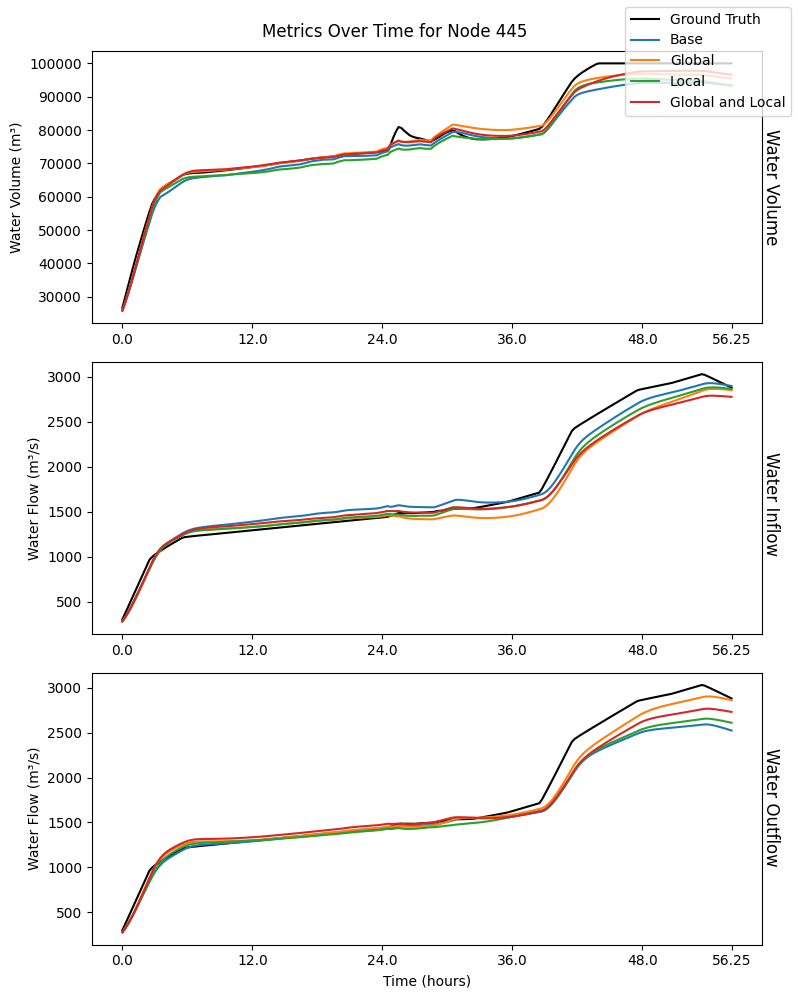

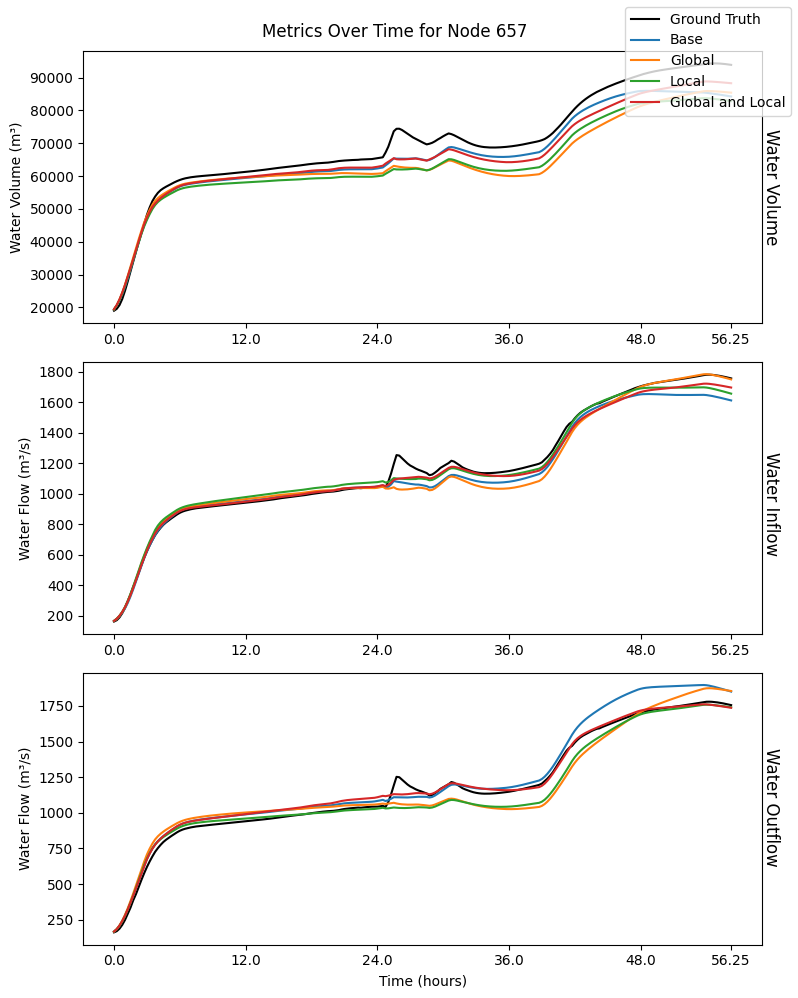

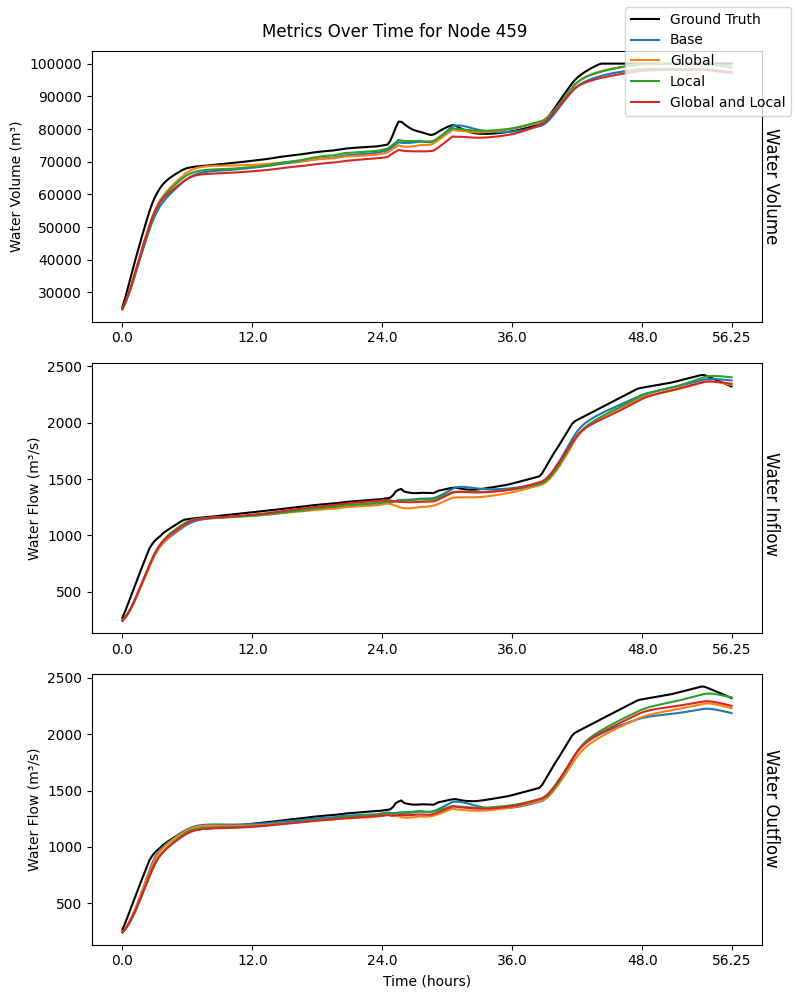

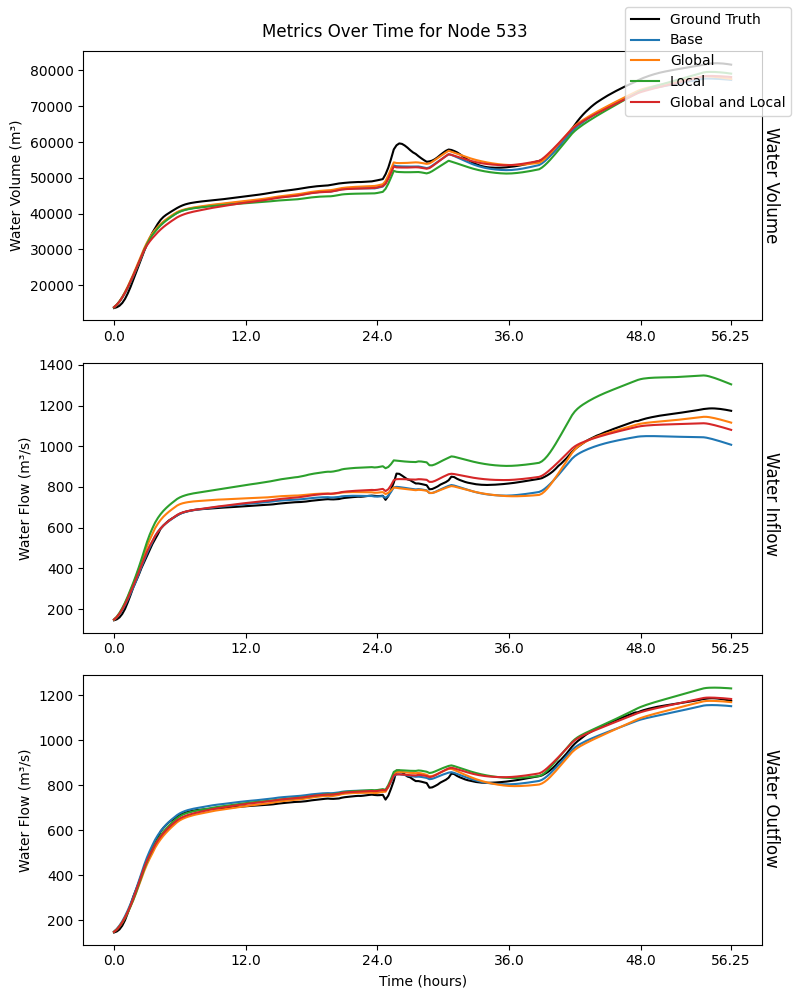

In [21]:
constant_values_path = 'data/datasets/processed/constant_values.npz'
edge_index = get_edge_index(constant_values_path)
flow_ground_truth = np.load(metric_paths[0], allow_pickle=True)['edge_target']

for node_idx in node_idxs:
    plot_node_water_values_for_all_models(metric_paths,
                                          node_idx,
                                          edge_index,
                                          ground_truths=(vol_ground_truth, flow_ground_truth),
                                          labels=labels)

In [22]:
for node in node_idxs:
    print(f'Calculating NSE for node {node}...')
    node_gt = torch.Tensor(vol_ground_truth[:, node])
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        node_pred = torch.Tensor(pred[:, node])
        nse = metric_utils.NSE(node_pred, node_gt)
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tNSE for {label}: {nse:.4f}')

Calculating NSE for node 445...
	NSE for Base: 0.9434
	NSE for Global: 0.9794
	NSE for Local: 0.9555
	NSE for Global and Local: 0.9828
Calculating NSE for node 657...
	NSE for Base: 0.9208
	NSE for Global: 0.7853
	NSE for Local: 0.7927
	NSE for Global and Local: 0.9223
Calculating NSE for node 459...
	NSE for Base: 0.9699
	NSE for Global: 0.9792
	NSE for Local: 0.9825
	NSE for Global and Local: 0.9488
Calculating NSE for node 533...
	NSE for Base: 0.9762
	NSE for Global: 0.9829
	NSE for Local: 0.9661
	NSE for Global and Local: 0.9743


### Flood Map Analysis

In [23]:
def get_max_flood_map(metric_path: str, property: str) -> np.ndarray:
    per_cell_volume = np.load(metric_path, allow_pickle=True)[property]
    max_flood_map = per_cell_volume.max(axis=0)
    return max_flood_map

def get_node_df(config: dict, run_id: str, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    nodes_shp_file = dataset_parameters['nodes_shp_file']
    nodes_shp_path = os.path.join(root_dir, 'raw', nodes_shp_file)
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(root_dir=root_dir,
                               hec_ras_file=hec_ras_file,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes,
                               saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
        node_df = node_df[~node_df['CC_index'].isin(bc.ghost_nodes)]

    return node_df

def get_axis_from_subplot(axes, nrows: int, ncols: int, index: int) -> plt.Axes:
    if nrows == 1:
        return axes[index]
    else:
        ax_row = index // ncols
        ax_col = index % ncols
        return axes[ax_row, ax_col]

def hide_remaining_axes(axes, start_index: int, nrows: int, ncols: int):
    total_axes = nrows * ncols
    for i in range(start_index, total_axes):
        ax = get_axis_from_subplot(axes, nrows, ncols, i)
        ax.set_visible(False)
        ax.set_axis_off()

def plot_cell_map(axis, gpdf: gpd.GeoDataFrame, value: np.ndarray, title: str, cmap = None, vmin: float = None, vmax: float = None):
    value_column = 'is_flooded'
    if cmap is None:
        cmap = plt.get_cmap('viridis') 
    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        'linewidth': 0.3,
        'markersize': 3,
    }

    # Add vmin/vmax if provided for consistent color scaling
    if vmin is not None and vmax is not None:
        shared_plot_kwargs['vmin'] = vmin
        shared_plot_kwargs['vmax'] = vmax

    gpdf[value_column] = value
    plot_obj = gpdf.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

    return plot_obj

def plot_max_flood_map_for_all_models(metric_paths: list[str],
                                      node_df: gpd.GeoDataFrame,
                                      ground_truth: np.ndarray = None,
                                      labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max flood maps for event {event_name}')
    index = 0

    # Get max flood maps for all paths
    max_flood_maps = []
    vmin = np.inf if ground_truth is None else ground_truth.min()
    vmax = -np.inf if ground_truth is None else ground_truth.max()
    data_shape = None
    for path in metric_paths:
        pred = get_max_flood_map(path, 'pred')
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        # vmin = min(vmin, pred.min())
        # vmax = max(vmax, pred.max())
        max_flood_maps.append(pred)

    # Plot ground truth
    plot_obj = None
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', 
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_flood_maps):
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, map_data, title=labels[i],
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    if plot_obj is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
        cbar.set_label('Water Volume (m³)', rotation=270, labelpad=15)
    
    hide_remaining_axes(ax, index, nrows, ncols)
    plt.subplots_adjust(right=0.9)
    # plt.tight_layout()
    plt.show()

In [24]:
max_flood_map_gt = get_max_flood_map(metric_paths[0], 'target')

print(f'Calculating RMSE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    rmse = metric_utils.RMSE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tRMSE for {label}: {rmse:.4f}')

print(f'Calculating MAE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    mae = metric_utils.MAE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tMAE for {label}: {mae:.4f}')

Calculating RMSE for max flood maps...
	RMSE for Base: 4263.0732
	RMSE for Global: 3916.0256
	RMSE for Local: 3773.5474
	RMSE for Global and Local: 5069.3750
Calculating MAE for max flood maps...
	MAE for Base: 2522.8091
	MAE for Global: 2281.0854
	MAE for Local: 2218.6008
	MAE for Global and Local: 2475.4531


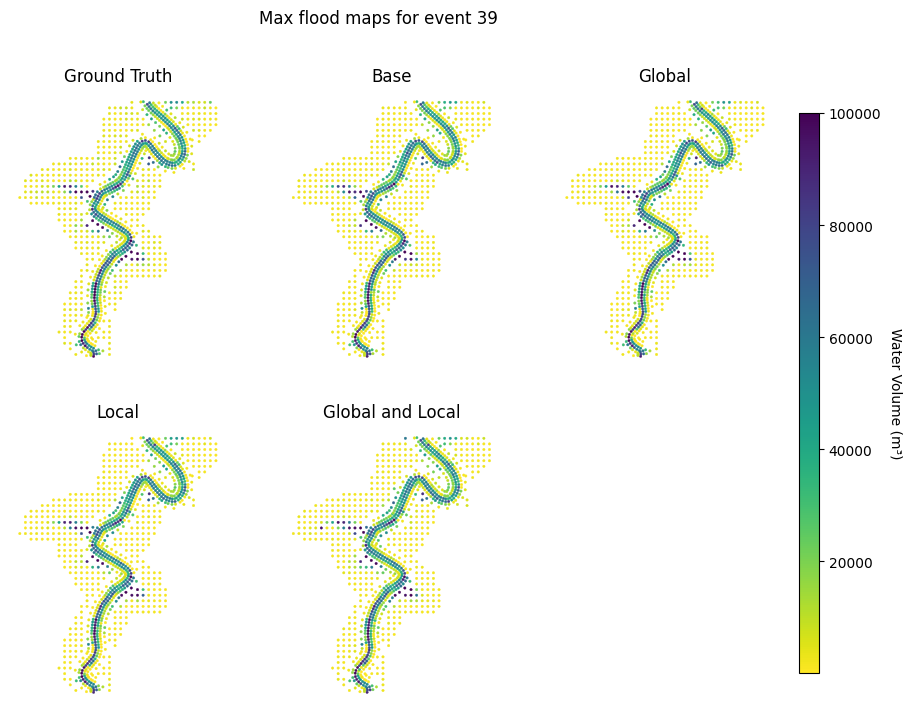

In [25]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

gpdf = get_node_df(config, RUN_ID, no_ghost=True)
plot_max_flood_map_for_all_models(metric_paths,
                                  gpdf,
                                  labels=labels,
                                  ground_truth=max_flood_map_gt)

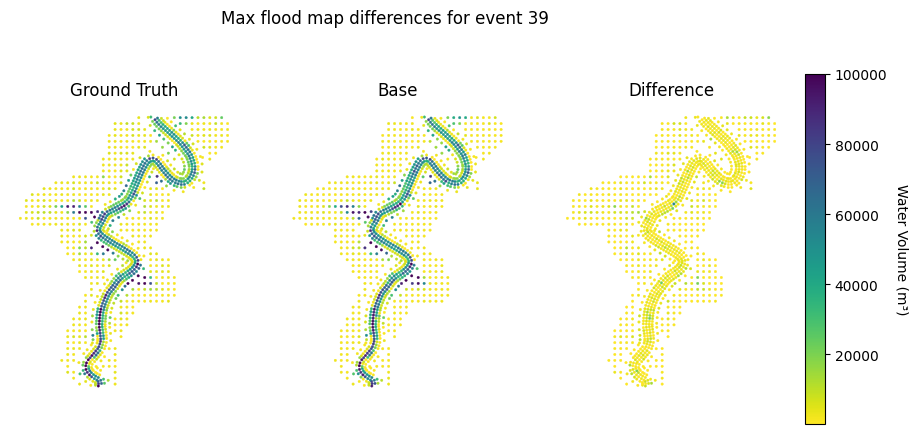

In [32]:
def plot_max_flood_map_difference(metric_path: str,
                                  node_df: gpd.GeoDataFrame,
                                  ground_truth: np.ndarray,
                                  label: str = None):

    event_name = metric_path.split('/')[-1].split('_')[-3]
    cmap = plt.get_cmap('viridis_r')

    fig, ax = plt.subplots(figsize=(10,5), ncols=3)
    fig.suptitle(f'Max flood map differences for event {event_name}')

    vmin = ground_truth.min()
    vmax = ground_truth.max()

    # Plot ground truth
    plot_obj = plot_cell_map(ax[0], node_df, ground_truth, title='Ground Truth', 
                                cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Plot prediction
    pred = get_max_flood_map(metric_path, 'pred')
    title = label if label is not None else 'Prediction'
    plot_cell_map(ax[1], node_df, pred, title=title, cmap=cmap, vmin=vmin, vmax=vmax)


    diff_map = np.abs(ground_truth - pred)
    plot_cell_map(ax[2], node_df, diff_map, title='Difference', cmap=cmap, vmin=vmin, vmax=vmax)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label('Water Volume (m³)', rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9)

    # plt.tight_layout()
    plt.show()

PATH_IDX = 0
plot_max_flood_map_difference(metric_path=metric_paths[PATH_IDX],
                              node_df=gpdf,
                              ground_truth=max_flood_map_gt,
                              label=labels[PATH_IDX] if labels is not None else None)

In [33]:
def get_volume_theshold_per_cell(config: dict, constant_values_path: str, run_id: str, percent_of_area: float = 0.05) -> np.ndarray:
    dataset_parameters = config['dataset_parameters']

    # Get area
    constant_values = np.load(constant_values_path)
    static_nodes = constant_values['static_nodes']
    static_nodes = np.load(constant_values_path)['static_nodes']
    area_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('area')
    area = static_nodes[:, area_idx]

    # Denormalize
    if dataset_parameters['normalize']:
        root_dir = dataset_parameters['root_dir']
        features_stats_file = dataset_parameters['features_stats_file']
        normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
        area = normalizer.denormalize('area', area)

    # Filter out boundary nodes
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]
    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

    inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
    outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

    bc = BoundaryCondition(root_dir=root_dir,
                            hec_ras_file=hec_ras_file,
                            inflow_boundary_nodes=inflow_boundary_nodes,
                            outflow_boundary_nodes=outflow_boundary_nodes,
                            saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
    non_boundary_nodes_mask = ~bc.boundary_nodes_mask
    area = area[non_boundary_nodes_mask, None]

    # Get threshold
    threshold_per_cell = area * percent_of_area
    return threshold_per_cell

def convert_water_to_binary(water_volume: np.ndarray, water_threshold: np.ndarray) -> np.ndarray:
    return (water_volume > water_threshold).astype(int).squeeze()

def plot_binary_max_flood_map_for_all_models(metric_paths: list[str],
                                             node_df: gpd.GeoDataFrame,
                                             water_threshold: np.ndarray,
                                             ground_truth: np.ndarray = None,
                                             labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    cmap = plt.get_cmap('seismic_r')
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Binary max flood maps for event {event_name}')
    index = 0

    # Get max flood maps for all paths
    max_flood_maps = []
    data_shape = None
    for path in metric_paths:
        pred = get_max_flood_map(path, 'pred')
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        pred = convert_water_to_binary(pred, water_threshold)
        max_flood_maps.append(pred)

    # Plot ground truth
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', cmap=cmap)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_flood_maps):
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_cell_map(axis, node_df, map_data, title=labels[i], cmap=cmap)
        index += 1

    # Add shared legend for binary values
    legend_elements = [
        Patch(facecolor=cmap(0.0), label='Not Flooded'),
        Patch(facecolor=cmap(1.0), label='Flooded')
    ]
    
    fig.legend(handles=legend_elements, 
                loc='center right', 
                bbox_to_anchor=(0.98, 0.5),
                frameon=True,
                fancybox=True,
                shadow=True)

    hide_remaining_axes(ax, index, nrows, ncols)
    plt.tight_layout()
    plt.subplots_adjust(right=0.88)
    plt.show()

In [34]:
PERCENT_OF_AREA = 0.05

water_threshold = get_volume_theshold_per_cell(config, constant_values_path, RUN_ID, percent_of_area=PERCENT_OF_AREA)
binary_max_flood_map_gt = max_flood_map_gt > water_threshold
print(f'Ground truth num flooded cells: {binary_max_flood_map_gt.sum()}')
print(f'Calculating CSI (threshold = ({PERCENT_OF_AREA})) for max flood maps...')
binary_gt_max_map = torch.Tensor(binary_max_flood_map_gt).to(torch.bool)
for i, path in enumerate(metric_paths):
    pred_max_flood_map = get_max_flood_map(path, 'pred')
    binary_pred_max_map = torch.Tensor((pred_max_flood_map > water_threshold)).to(torch.bool)
    csi = metric_utils.CSI(binary_pred_max_map, binary_gt_max_map)
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tCSI for {label}: {csi:.4f} (Num flooded cells: {binary_pred_max_map.sum().item()})')

Ground truth num flooded cells: 875
Calculating CSI (threshold = (0.05)) for max flood maps...
	CSI for Base: 0.8355 (Num flooded cells: 832)
	CSI for Global: 0.8275 (Num flooded cells: 810)
	CSI for Local: 0.8218 (Num flooded cells: 781)
	CSI for Global and Local: 0.8577 (Num flooded cells: 875)


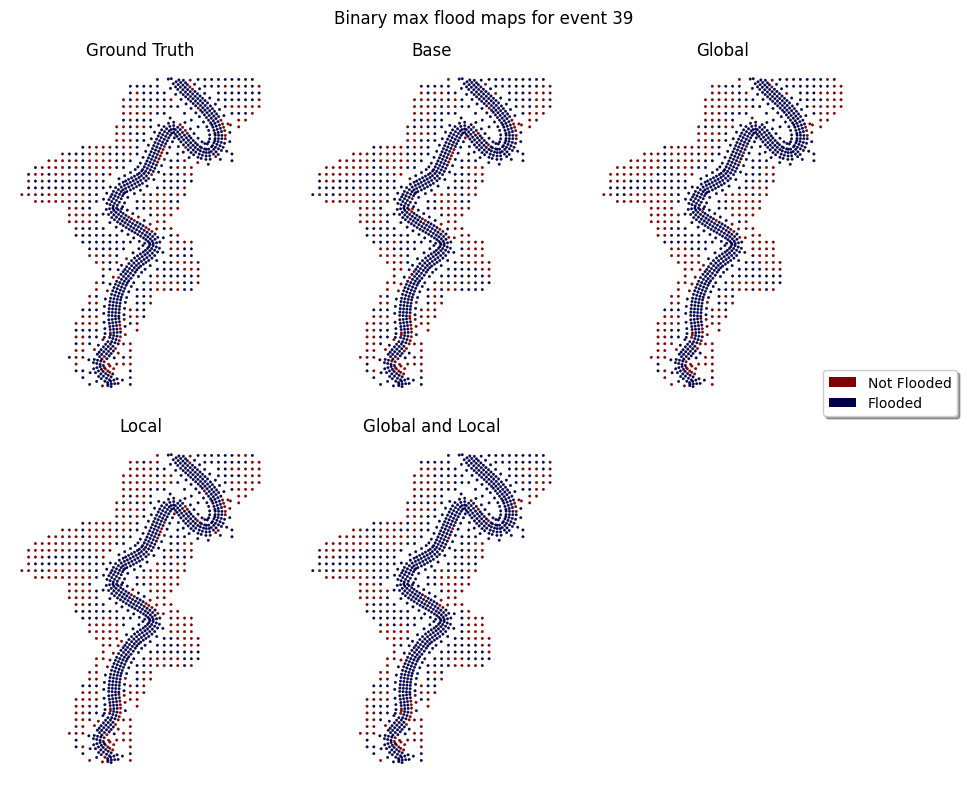

In [35]:
plot_binary_max_flood_map_for_all_models(metric_paths,
                                         gpdf,
                                         water_threshold,
                                         labels=labels,
                                         ground_truth=binary_max_flood_map_gt)

In [36]:
def get_max_flow_map(metric_path: str, property: str) -> np.ndarray:
    data = np.load(metric_path, allow_pickle=True)
    if property not in data or data[property] is None or len(data[property]) == 0:
        return None
    
    per_edge_flow = data[property]
    per_edge_flow = np.abs(per_edge_flow) # Use absolute value as we don't care about direction
    max_flow_map = per_edge_flow.max(axis=0)
    return max_flow_map

def get_edge_df(config: dict, run_id: str, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    edges_shp_file = dataset_parameters['edges_shp_file']
    edges_shp_path = os.path.join(root_dir, 'raw', edges_shp_file)
    link_df = gpd.read_file(edges_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(root_dir=root_dir,
                               hec_ras_file=hec_ras_file,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes,
                               saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
        is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
        boundary_nodes = np.concat([np.array(inflow_boundary_nodes), np.array(outflow_boundary_nodes)])
        is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
        link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

        assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
        assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

    return link_df

def plot_max_flow_map_for_all_models(metric_paths: list[str],
                                     edge_df: gpd.GeoDataFrame,
                                     ground_truth: np.ndarray = None,
                                     labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max flow maps for event {event_name}')
    index = 0

    # Get max flow maps for all paths
    max_flow_maps = []
    vmin = np.inf if ground_truth is None else ground_truth.min()
    vmax = -np.inf if ground_truth is None else ground_truth.max()
    data_shape = None
    for path in metric_paths:
        pred = get_max_flow_map(path, 'edge_pred')
        if pred is None:
            max_flow_maps.append(None)
            continue

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        # vmin = min(vmin, pred.min())
        # vmax = max(vmax, pred.max())
        max_flow_maps.append(pred)

    # Plot ground truth
    plot_obj = None
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, edge_df, ground_truth, title='Ground Truth', 
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_flow_maps):
        if map_data is None:
            continue

        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, edge_df, map_data, title=labels[i],
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    if plot_obj is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
        cbar.set_label('Water Flow (m³/s)', rotation=270, labelpad=15)
    
    hide_remaining_axes(ax, index, nrows, ncols)
    plt.subplots_adjust(right=0.9)
    plt.show()

In [37]:
flow_gt_path_idx = 3
max_flow_map_gt = get_max_flow_map(metric_paths[flow_gt_path_idx], 'edge_target')

print(f'Calculating RMSE for max flow maps...')
for i, path in enumerate(metric_paths):
    data = np.load(path, allow_pickle=True)
    if 'edge_pred' not in data or data['edge_pred'] is None or len(data['edge_pred']) == 0:
        print(f"Skipping RMSE calculation for {path} as 'edge_pred' not found in the data.")
        continue

    pred_max_flow_map = torch.Tensor(get_max_flow_map(path, 'edge_pred'))
    rmse = metric_utils.RMSE(pred_max_flow_map, torch.Tensor(max_flow_map_gt))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tRMSE for {label}: {rmse:.4f}')

Calculating RMSE for max flow maps...
	RMSE for Base: 81.8288
	RMSE for Global: 79.4396
	RMSE for Local: 70.8925
	RMSE for Global and Local: 69.8171


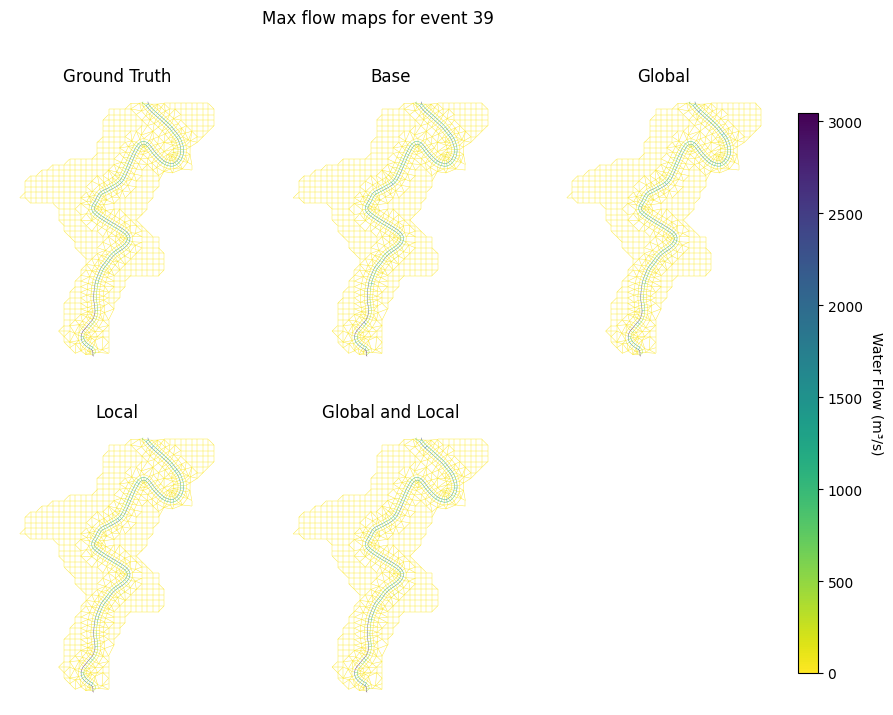

In [38]:
edge_df = get_edge_df(config, RUN_ID, no_ghost=True)
plot_max_flow_map_for_all_models(metric_paths,
                                 edge_df,
                                 labels=labels,
                                 ground_truth=max_flow_map_gt)

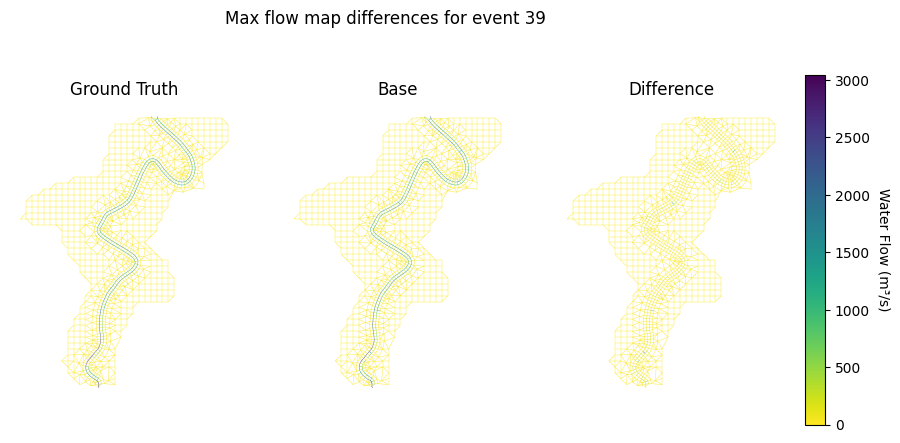

In [39]:
def plot_max_flow_map_difference(metric_path: str,
                                 edge_df: gpd.GeoDataFrame,
                                 ground_truth: np.ndarray,
                                 label: str = None):

    event_name = metric_path.split('/')[-1].split('_')[-3]
    cmap = plt.get_cmap('viridis_r')

    fig, ax = plt.subplots(figsize=(10,5), ncols=3)
    fig.suptitle(f'Max flow map differences for event {event_name}')

    vmin = ground_truth.min()
    vmax = ground_truth.max()

    # Plot ground truth
    plot_obj = plot_cell_map(ax[0], edge_df, ground_truth, title='Ground Truth', 
                                cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Plot prediction
    pred = get_max_flow_map(metric_path, 'edge_pred')
    title = label if label is not None else 'Prediction'
    plot_cell_map(ax[1], edge_df, pred, title=title, cmap=cmap, vmin=vmin, vmax=vmax)

    # Plot difference
    diff_map = np.abs(ground_truth - pred)
    plot_cell_map(ax[2], edge_df, diff_map, title='Difference', cmap=cmap, vmin=vmin, vmax=vmax)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label('Water Flow (m³/s)', rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9)

    # plt.tight_layout()
    plt.show()

PATH_IDX = 0
plot_max_flow_map_difference(metric_path=metric_paths[PATH_IDX],
                              edge_df=edge_df,
                              ground_truth=max_flow_map_gt,
                              label=labels[PATH_IDX] if labels is not None else None)